In [1]:
import os
import numpy as np
import time
from scipy.special import erfinv
from numpy import log, pi,sqrt, exp,cos,sin,tan,argpartition,copy,trapz,mean,cov,vstack,hstack
import matplotlib.pyplot as plt
import random
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
def dataload(data):
    Pk0 = [[],[]]
    Pk2 = [[],[]]
    k = data[0,:,1]
    l0 = data[:,:,3]
    l2 = data[:,:,4]
    Pk0[0] = np.mean(l0,axis=0)
    Pk0[1] = np.std(l0,axis=0)
    Pk2[0] = np.mean(l2,axis=0)
    Pk2[1] = np.std(l2,axis=0)
    pk_cov = np.append(l0,l2,axis=1)
    cov = np.cov(np.array(pk_cov).T)
    # icov = np.linalg.inv(cov)
    return (k,Pk0,Pk2, cov)

def Pkload(catalogue, r_pk, redshift):
    # load the QUIJOTE observation
    tool = 'Pypower' # Powspec, Pypower, NCV
    Ddir = f'/Users/alain/Desktop/projectNU/main/data/kbin2/{catalogue}/{r_pk}_z{redshift}/pk'
    data = []
    nb = np.arange(100,200,1)
    for h in nb:
        realisation=np.loadtxt(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
        data.append(realisation)
    print(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
    (kev, pk0, pk2, icov) = dataload(np.array(data))
    pkl = [kev, pk0, pk2, icov]
    return pkl

/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/LRG_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/LRG_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/QSO_z1.0/pk/fiducial_199_z1.0.pk


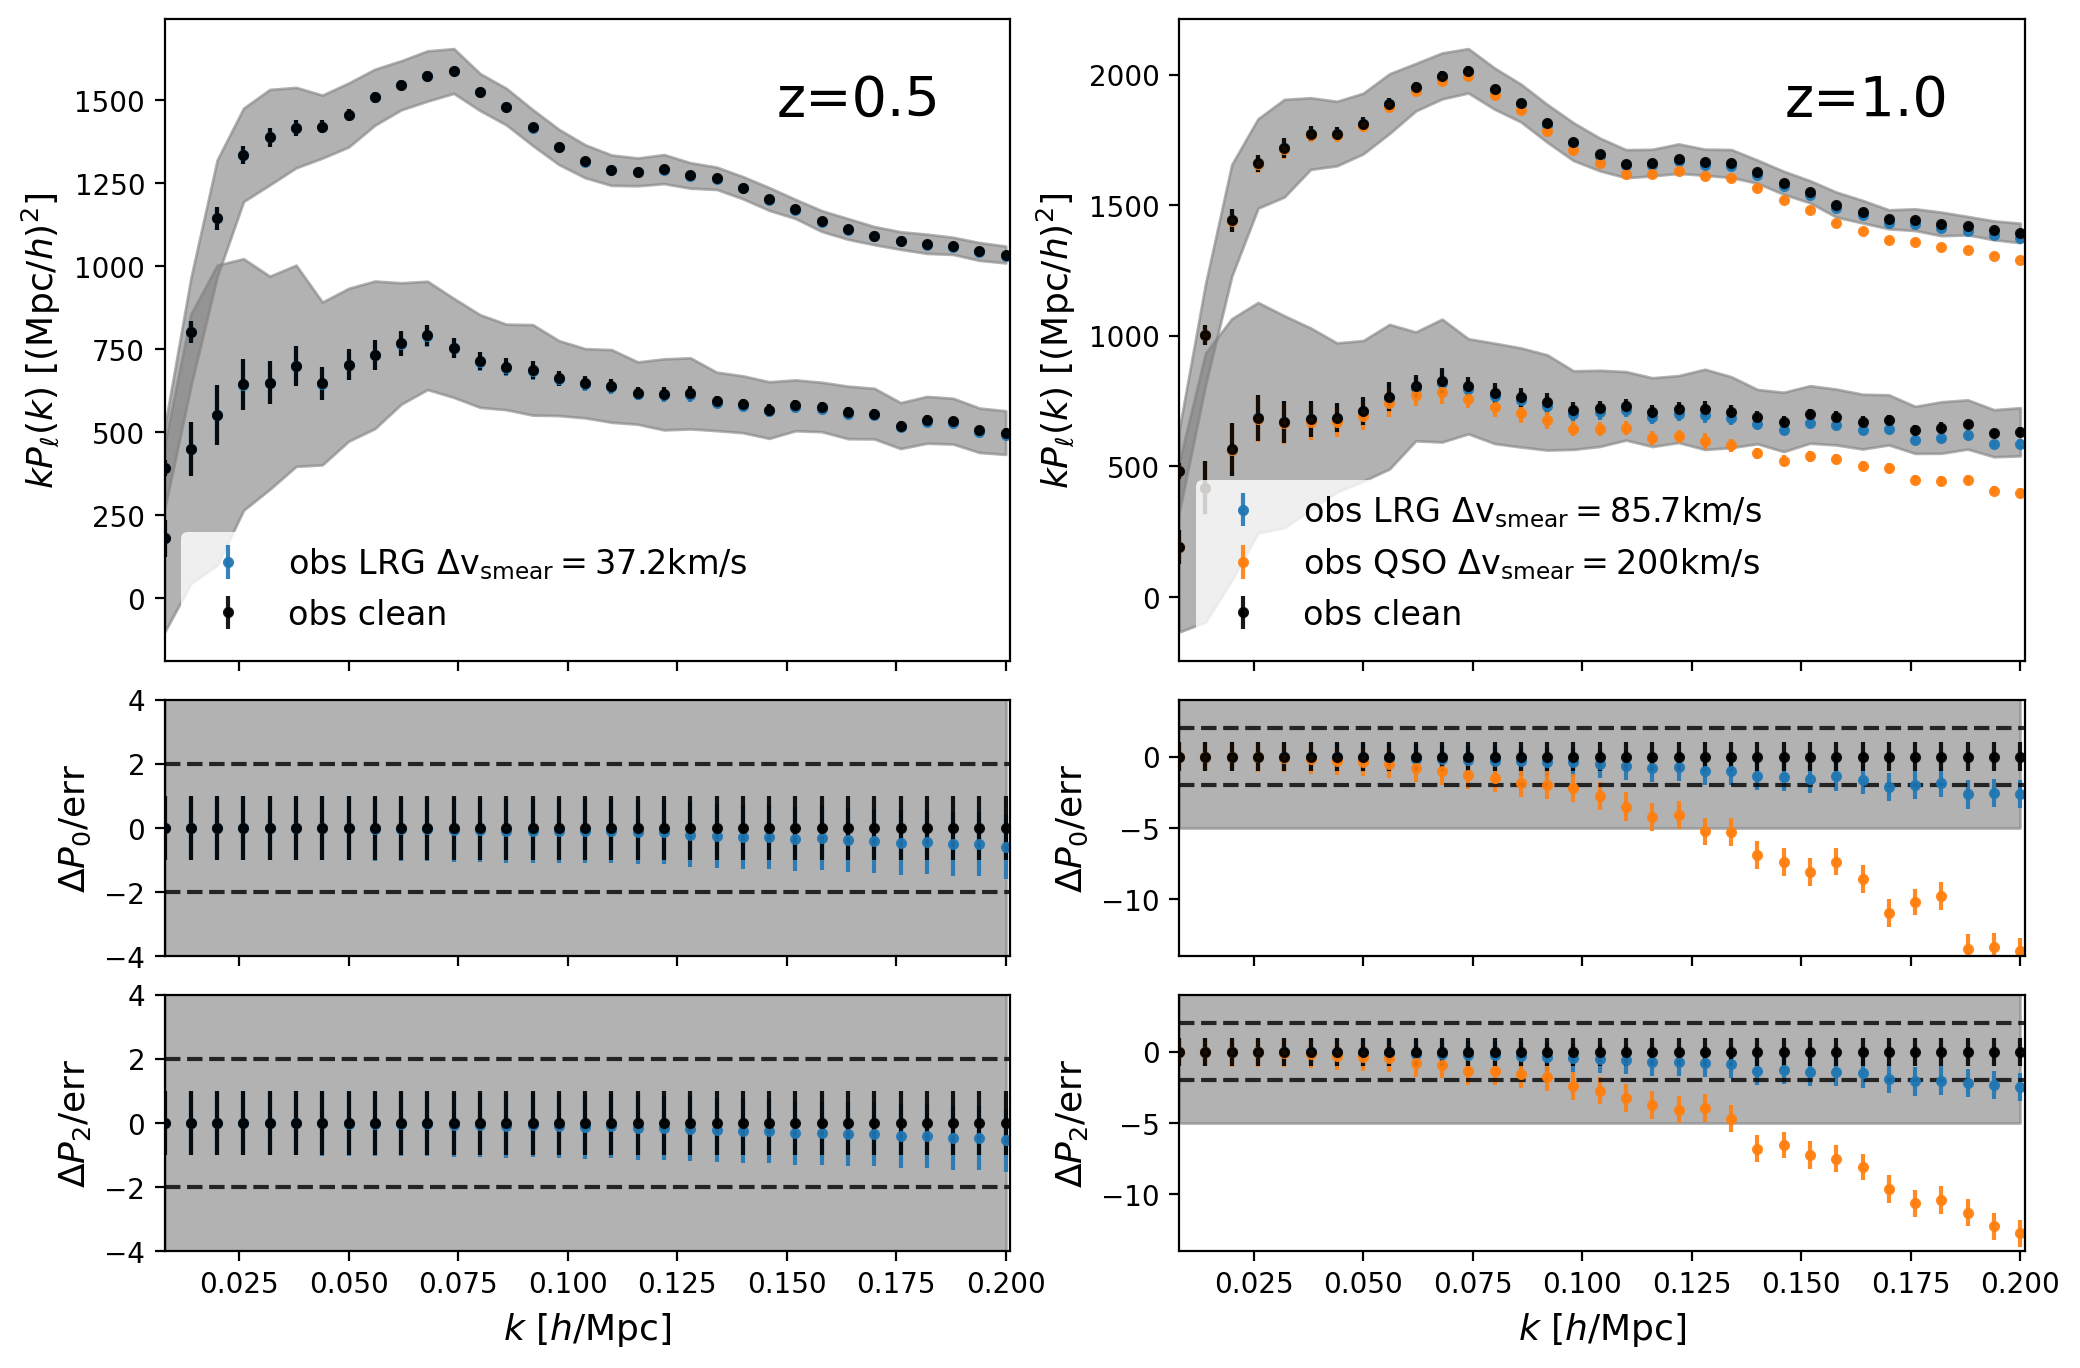

In [100]:
systematic_map  = {
    'RSD': 'fiducial',
    'LRG': '+LRGvsmear',
    'QSO': '+QSOvsmear',
    '1%CATAS': '+1%vcatas',
    '5%CATAS': '+5%vcatas'
    }

labels1 = [r'obs clean', r'$\rm{obs} \ \rm{LRG} \  \Delta v_{smear} =  37.2 \rm{km/s}$']
labels2 = [r'obs clean', r'$\rm{obs} \ \rm{LRG} \  \Delta v_{smear} =  85.7 \rm{km/s}$', r'$\rm{obs}\ \rm{QSO} \  \Delta v_{smear} =  200 \rm{km/s}$']

label_fontsize = 13
fig, axs = plt.subplots(3, 2, sharex=True, sharey=False, figsize = (12, 8),  
                        gridspec_kw={'height_ratios':[2.5]+[1]*2})
fig.subplots_adjust(hspace=0.1)
for z, redshift in enumerate([0.5, 1.0]):
    Pkobs   = []
    labels  = []
    colors = ['black', 'C0','C1']
    if redshift == 0.5:
        rpks = ['RSD','LRG']
    elif redshift == 1.0:
        rpks = ['RSD','LRG','QSO']
    for t,r_pk in enumerate(rpks):
        systematic = systematic_map.get(r_pk, '')
        [k_ev, pk0, pk2, cov] = Pkload('fiducial', r_pk, redshift)
        Pkobs.append([pk0, pk2])
        if t == 0:
            rsf = 5
            klen = len(k_ev)
            ref =  [i[0] for i in [pk0, pk2]] 
            errbar = [i[1] for i in [pk0, pk2]]
    for ell, l in zip(['monopole','quadrupole'],range(2)):
        values   = [np.zeros(klen), ref[l]]      
        err   = [np.ones(klen),k_ev*errbar[l]/rsf]
        for j in range(2):
            k = 0 if j==0 else l+j
            if redshift == 0.5:
                for t in [1,0]:
                    if t ==0:
                        axs[k][z].fill_between(k_ev,  k_ev*(Pkobs[t][l][0]-values[j]+Pkobs[t][l][1])/err[j] ,
                                            k_ev*(Pkobs[t][l][0]-values[j]-Pkobs[t][l][1])/err[j],alpha=0.6, color='grey')
                    axs[k][z].errorbar(k_ev, k_ev*(Pkobs[t][l][0]-values[j])/err[j], k_ev*Pkobs[t][l][1]/err[j]/rsf,
                                    color = colors[t], label = labels1[t], fmt='.', alpha = 0.9)
            if redshift == 1.0:
                for t in [1,2,0]:
                    if t ==0:
                        axs[k][z].fill_between(k_ev,  k_ev*(Pkobs[t][l][0]-values[j]+Pkobs[t][l][1])/err[j] ,
                                            k_ev*(Pkobs[t][l][0]-values[j]-Pkobs[t][l][1])/err[j],alpha=0.6, color='grey')
                    axs[k][z].errorbar(k_ev, k_ev*(Pkobs[t][l][0]-values[j])/err[j], k_ev*Pkobs[t][l][1]/err[j]/rsf,
                                    color = colors[t], label = labels2[t], fmt='.', alpha = 0.9)        
            if k == 0:
                axs[k][z].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]', fontsize = label_fontsize)
            if k==1 or k==2:
                axs[k][0].set_ylim(-4, 4)
                axs[k][1].set_ylim(-14, 4)
                axs[k][z].set_ylabel(r'$\Delta P_{}$/err'.format(l*2), fontsize = label_fontsize)
                for offset in [-2., 2.]: axs[k][z].axhline(offset, color='k', linestyle='--', alpha=0.8)

        if l==0: 
            leg1= axs[0][z].legend(loc=3, fontsize=12)
            leg1.get_frame().set_linewidth(0.0)
    axs[-1,z].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]', fontsize = label_fontsize)
plt.xlim([0.008,0.201])
plt.figtext(0.38, 0.82, f'z=0.5', fontsize=20)
plt.figtext(0.80, 0.82, f'z=1.0', fontsize=20)
plt.show()

/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/LRG_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/LRG_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/QSO_z1.0/pk/fiducial_199_z1.0.pk


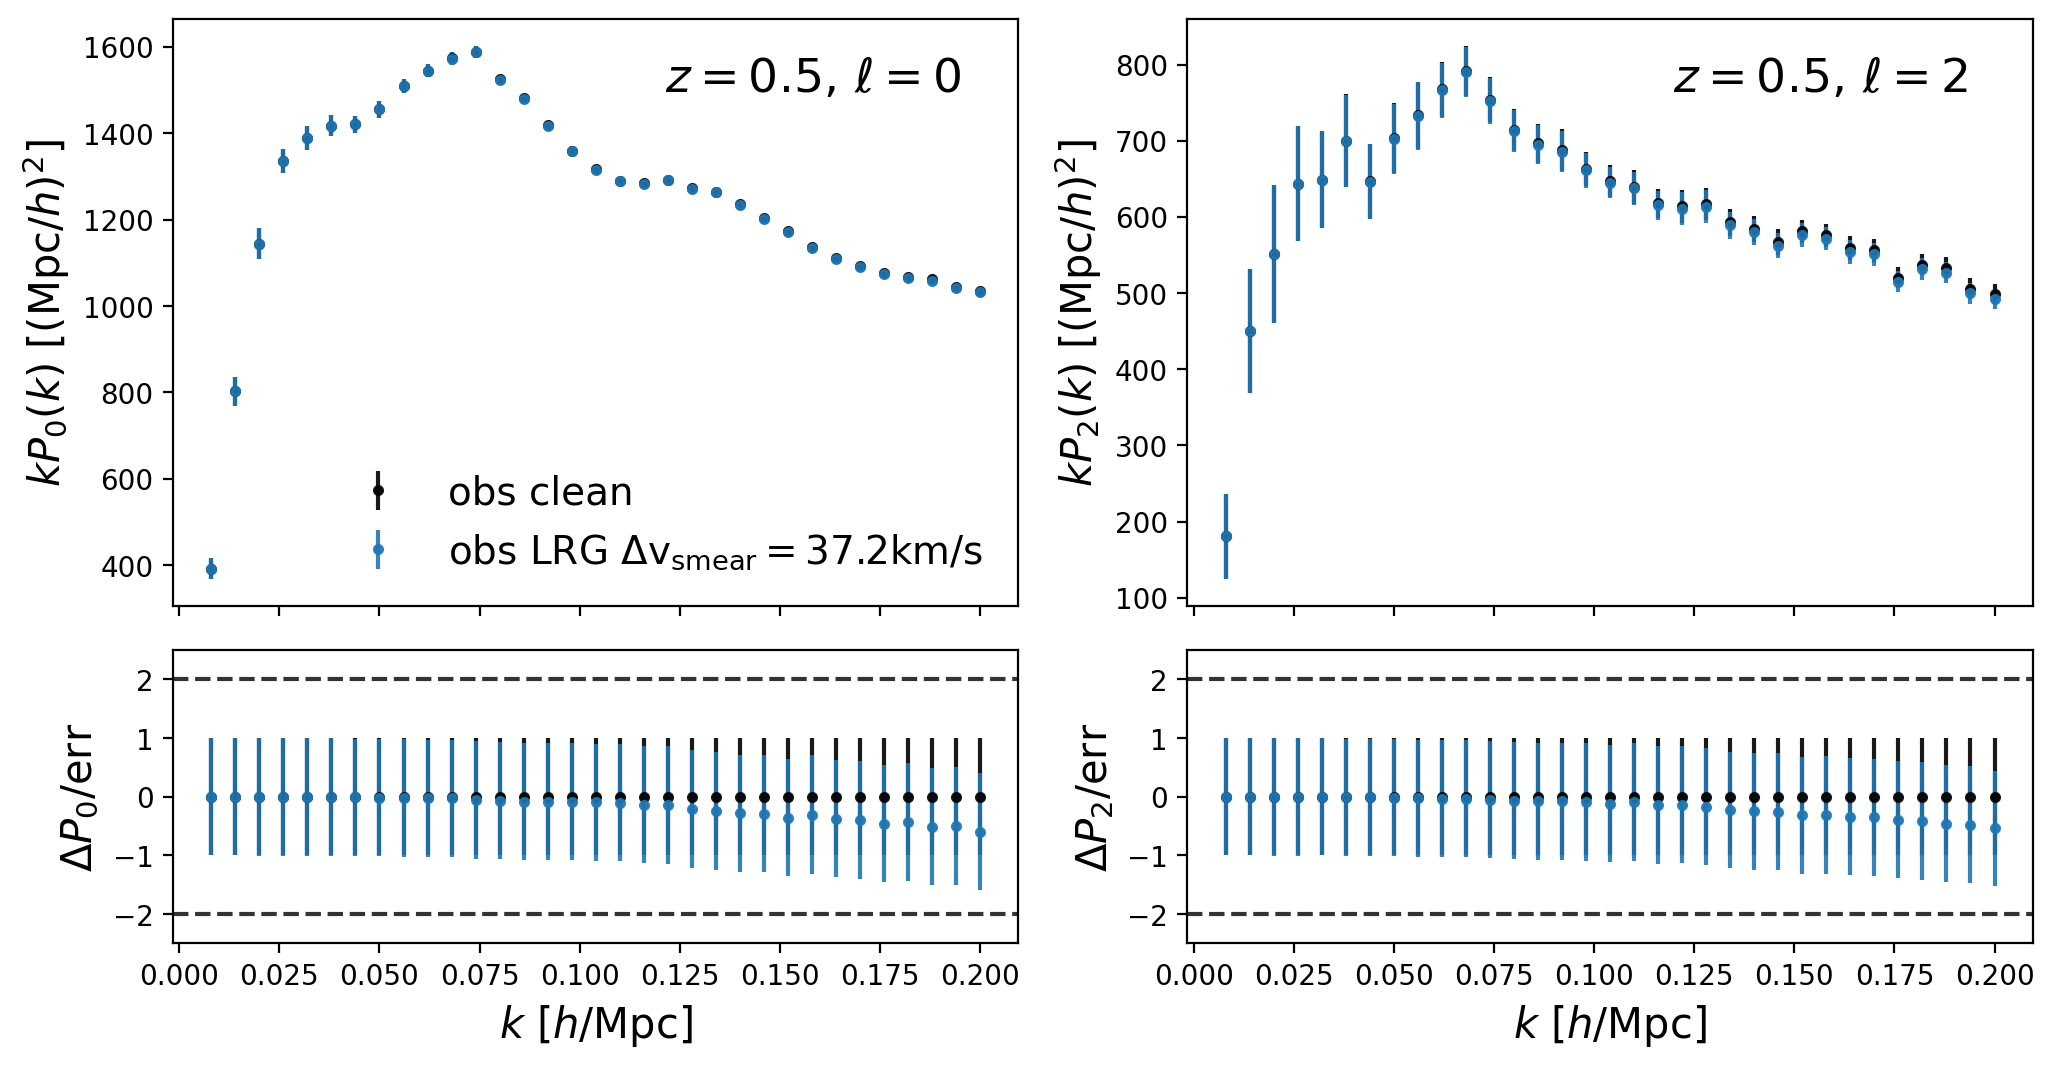

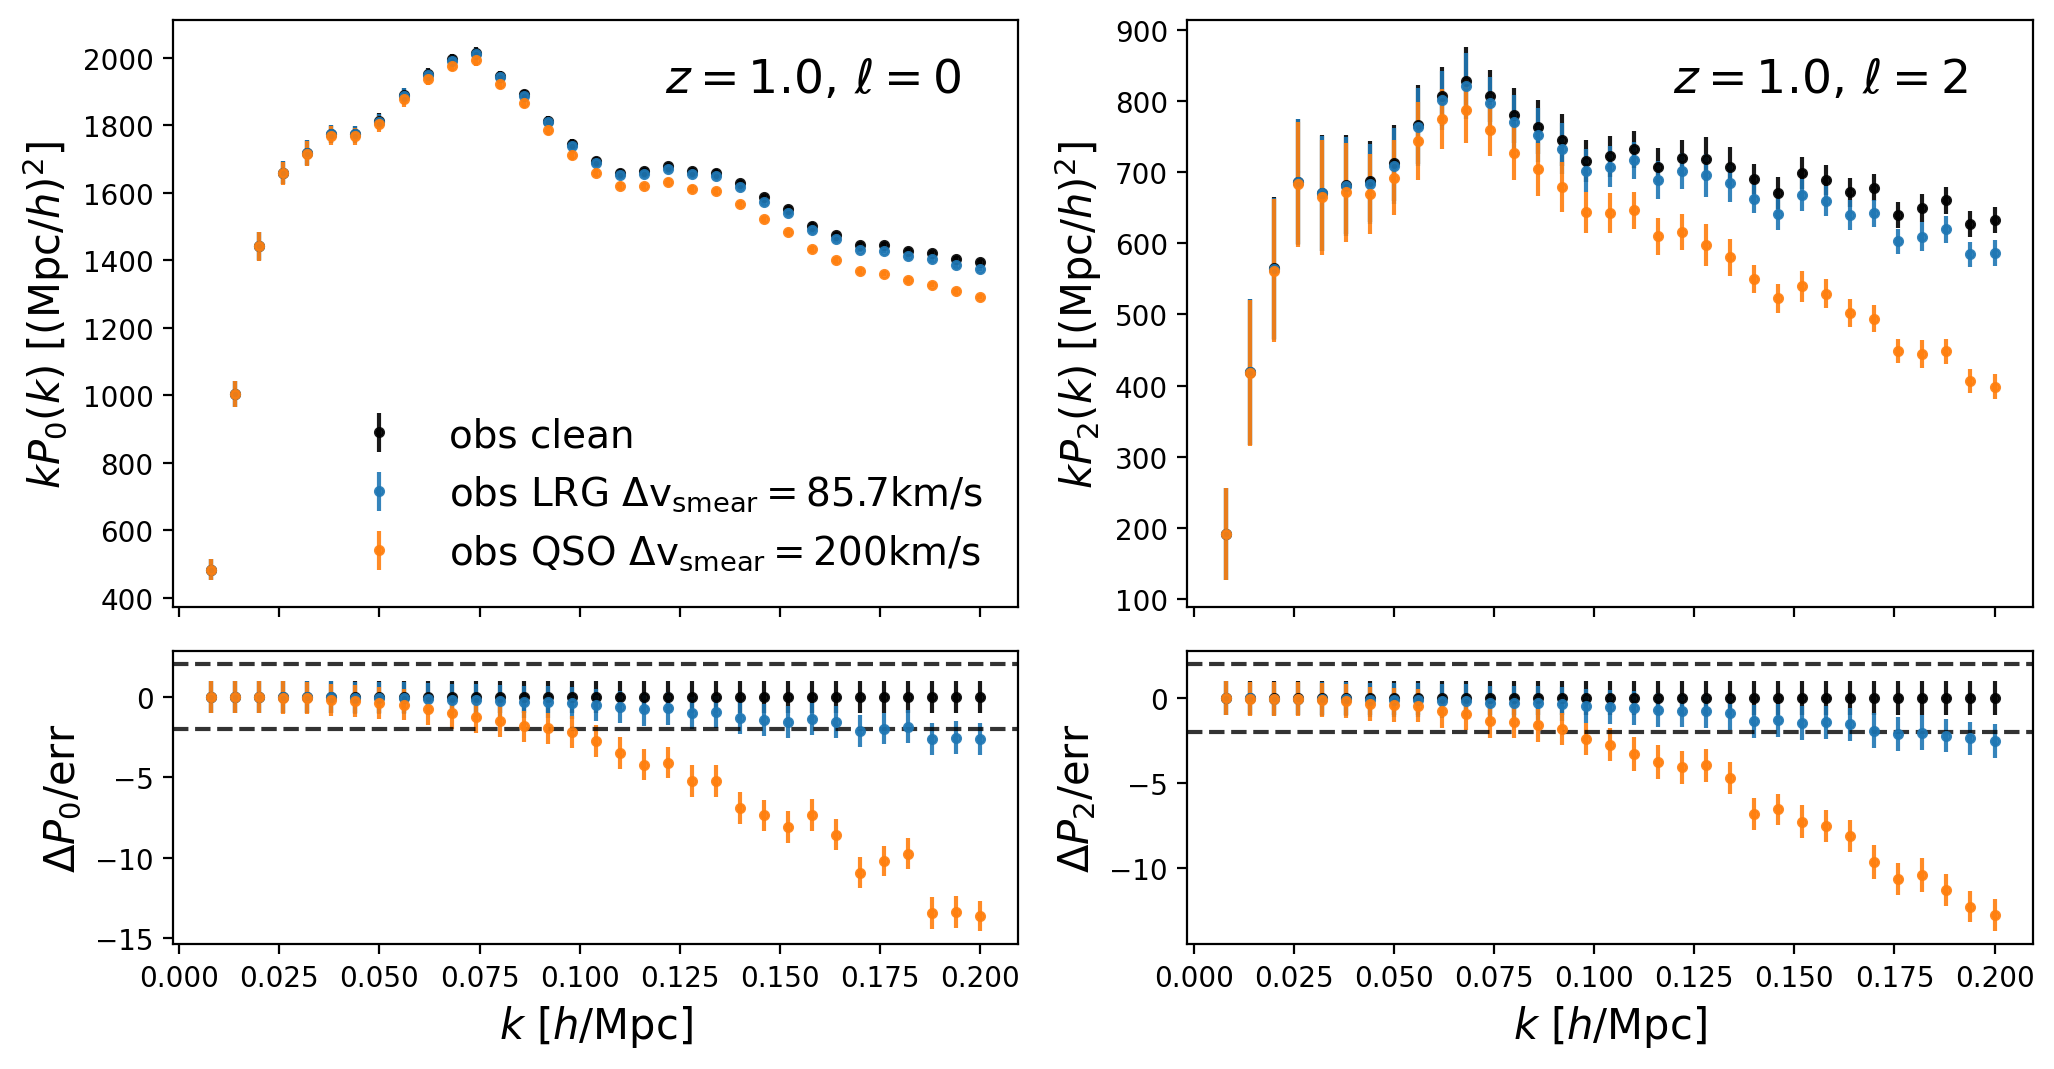

In [5]:
systematic_map  = {
    'RSD': 'fiducial',
    'LRG': '+LRGvsmear',
    'QSO': '+QSOvsmear',
    '1%CATAS': '+1%vcatas',
    '5%CATAS': '+5%vcatas'
    }

labels1 = [r'obs clean', r'$\rm{obs} \ \rm{LRG} \  \Delta v_{smear} =  37.2 \rm{km/s}$']
labels2 = [r'obs clean', r'$\rm{obs} \ \rm{LRG} \  \Delta v_{smear} =  85.7 \rm{km/s}$', r'$\rm{obs}\ \rm{QSO} \  \Delta v_{smear} =  200 \rm{km/s}$']
labels = [labels1,labels2]
ylabels = [r'$k P_0(k)$ [$(\mathrm{Mpc}/h)^{2}$]',r'$k P_2(k)$ [$(\mathrm{Mpc}/h)^{2}$]']

label_fontsize = 15
for z, redshift in enumerate([0.5, 1.0]):
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize = (12, 6),  
                        gridspec_kw={'height_ratios':[2]+[1]})
    fig.subplots_adjust(hspace=0.1)
    Pkobs   = []
    if redshift == 0.5:
        rpks = ['RSD','LRG']
        colors = ['black', 'C0']
    elif redshift == 1.0:
        rpks = ['RSD','LRG','QSO']
        colors = ['black', 'C0','C1']
    for t,r_pk in enumerate(rpks):
        systematic = systematic_map.get(r_pk, '')
        [k_ev, pk0, pk2, cov] = Pkload('fiducial', r_pk, redshift)
        Pkobs.append([pk0, pk2])
        if t == 0:
            rsf = 5
            klen = len(k_ev)
            ref =  [i[0] for i in [pk0, pk2]] 
            errbar = [i[1] for i in [pk0, pk2]]
    for ell, l in zip(['monopole','quadrupole'],range(2)):
        values   = [np.zeros(klen), ref[l]]      
        err   = [np.ones(klen),k_ev*errbar[l]/rsf]
        for j in range(2):
            for t in range(len(Pkobs)):
                # if t ==0:
                #     axs[j][l].fill_between(k_ev,  k_ev*(Pkobs[t][l][0]-values[j]+Pkobs[t][l][1])/err[j] ,
                #         k_ev*(Pkobs[t][l][0]-values[j]-Pkobs[t][l][1])/err[j],alpha=0.6, color='grey')
                axs[j][l].errorbar(k_ev,  k_ev*(Pkobs[t][l][0]-values[j])/err[j], k_ev*Pkobs[t][l][1]/err[j]/rsf,
                                color = colors[t], label = labels[z][t], fmt='.', alpha = 0.9)        
            if j == 0:
                axs[j][l].set_ylabel(ylabels[l], fontsize = label_fontsize)
                leg1= axs[j][0].legend(loc=4, fontsize=14)
                leg1.get_frame().set_linewidth(0.0)
            if j == 1:
                if redshift == 0.5:
                    axs[j][l].set_ylim(-2.5, 2.5)
                # axs[k][1].set_ylim(-14, 4)
                axs[j][l].set_ylabel(r'$\Delta P_{}$/err'.format(l*2), fontsize = label_fontsize)
                for offset in [-2., 2.]: axs[j][l].axhline(offset, color='k', linestyle='--', alpha=0.8)
        axs[-1,l].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]', fontsize = label_fontsize)
    # plt.xlim([0.008,0.201])
    plt.figtext(0.33, 0.82, r'$z={}, \, \ell=0 $'.format(redshift), fontsize=17)
    plt.figtext(0.75, 0.82, r'$z={},  \, \ell=2 $'.format(redshift), fontsize=17)
plt.show()

/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/1%CATAS_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/5%CATAS_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/1%CATAS_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/5%CATAS_z1.0/pk/fiducial_199_z1.0.pk


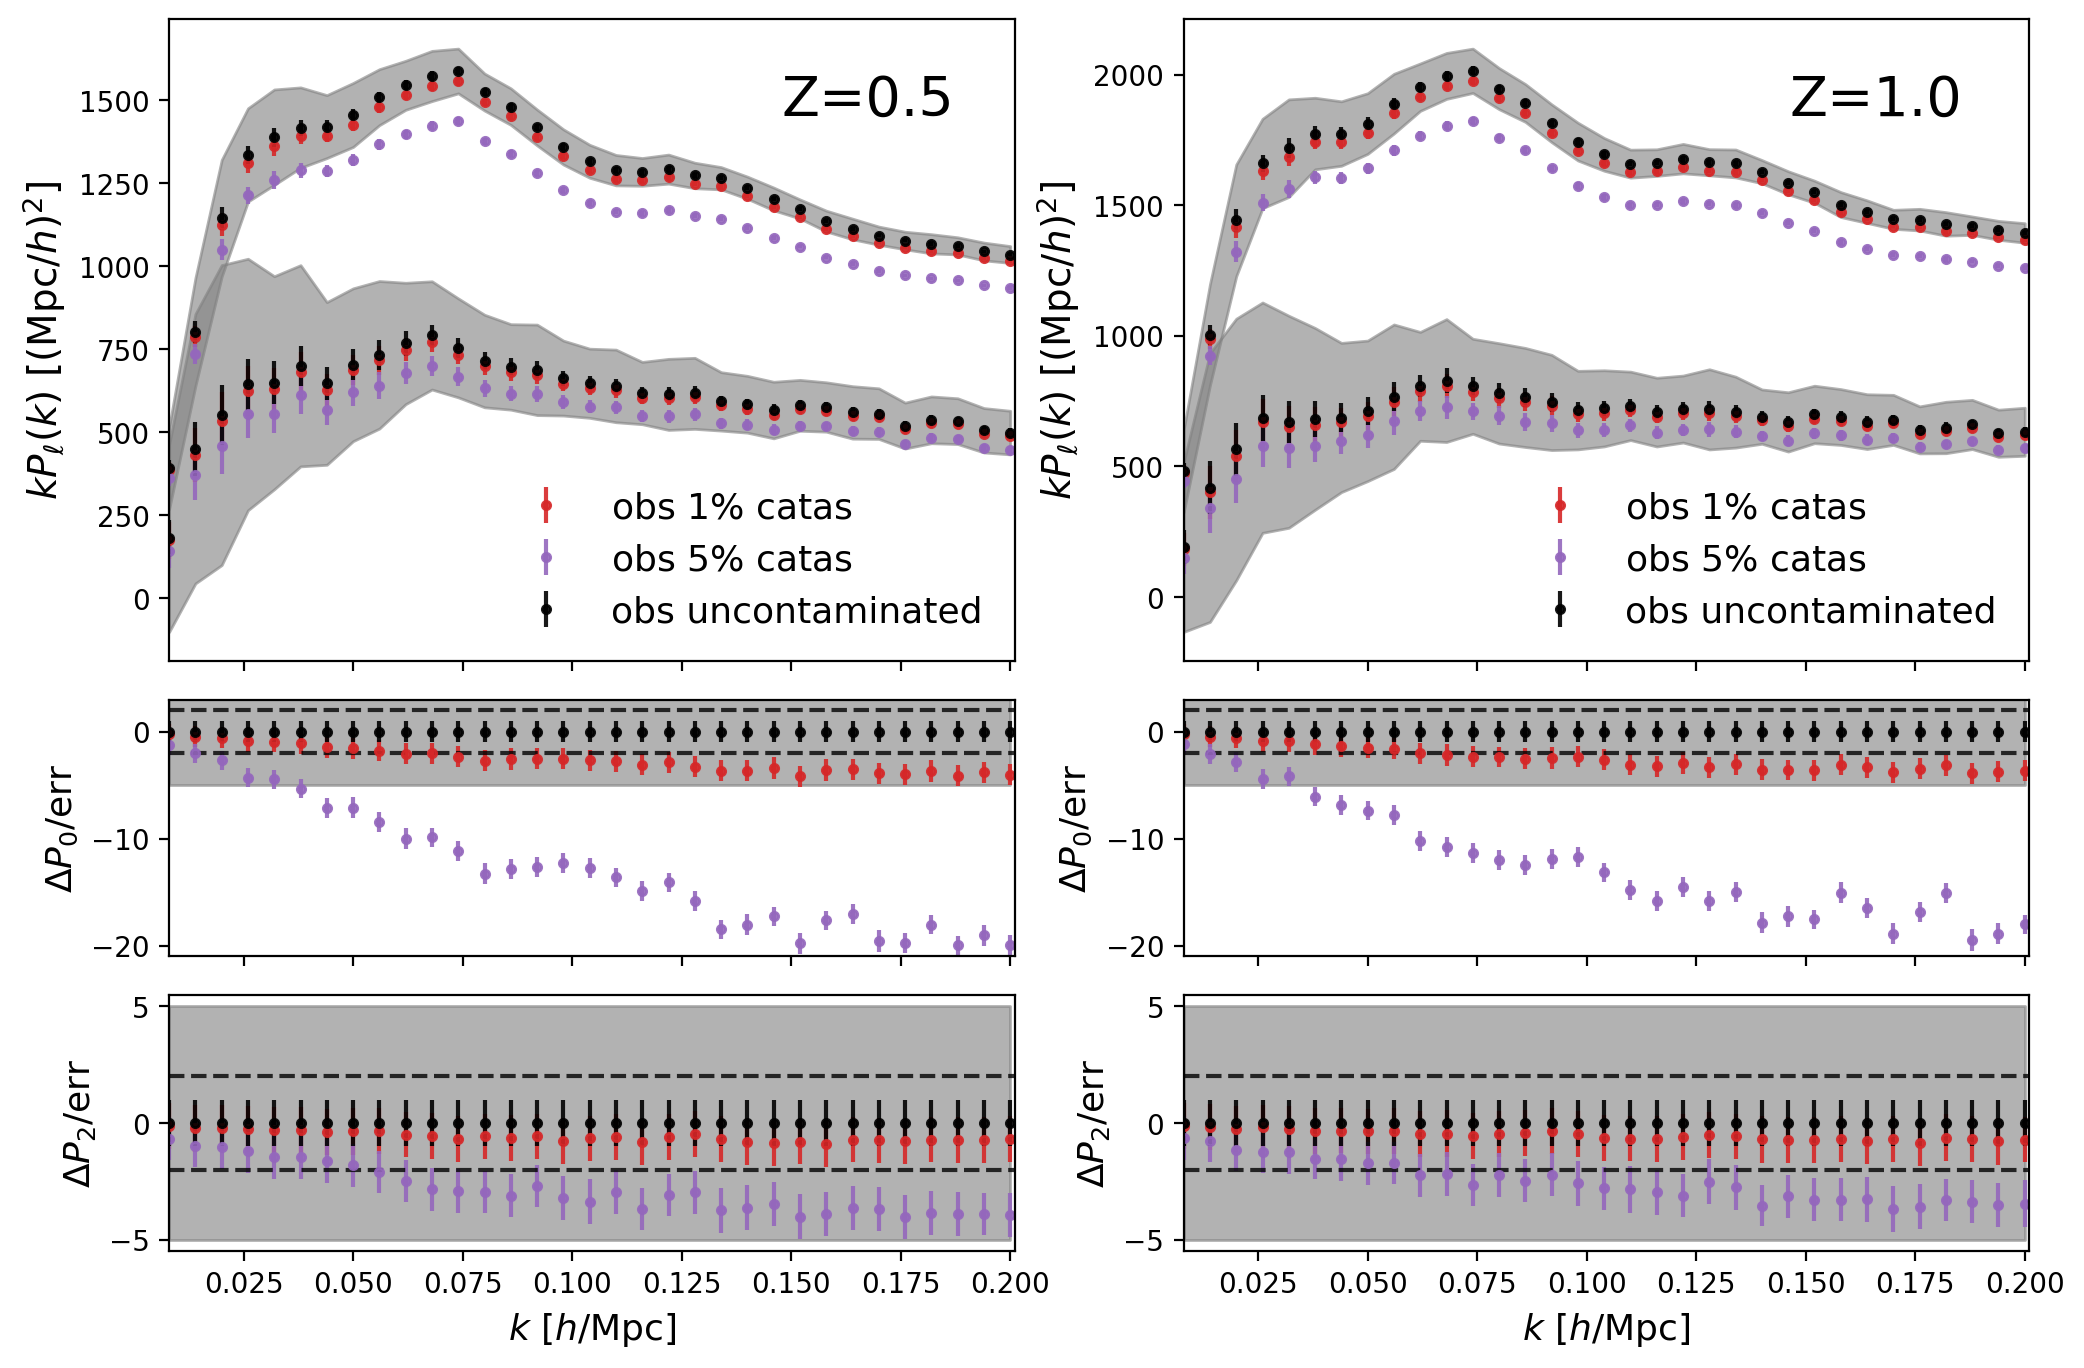

In [84]:
systematic_map  = {
    'RSD': 'fiducial',
    'LRG': '+LRG vsmear',
    'QSO': '+QSO vsmear',
    '1%CATAS': '+1%vcatas',
    '5%CATAS': '+5%vcatas'
    }

labels = [r'obs clean', r'$\rm{obs} \ 1\% \ catas $', r'$\rm{obs} \ 5\% \ catas $']

fig, axs = plt.subplots(3, 2, sharex=True, sharey=False, figsize = (12, 8),  
                        gridspec_kw={'height_ratios':[2.5]+[1]+[1]})
fig.subplots_adjust(hspace=0.1)
for z, redshift in enumerate([0.5, 1.0]):
    rsf = 5
    Pkobs   = []
    colors = ['black', 'C3', 'C4']
    for t,r_pk in enumerate(['RSD','1%CATAS','5%CATAS']):
        systematic = systematic_map.get(r_pk, '')
        [k_ev, pk0, pk2, cov] = Pkload('fiducial', r_pk, redshift)
        Pkobs.append([pk0, pk2])
        if t == 0:
            klen = len(k_ev)
            ref =  [i[0] for i in [pk0, pk2]] 
            errbar = [i[1] for i in [pk0, pk2]]
    for ell, i in zip(['monopole','quadrupole'],range(2)):
        values   = [np.zeros(klen), ref[i]]      
        err   = [np.ones(klen),k_ev*errbar[i]/rsf]
        for j in range(2):
            k = 0 if j==0 else i+j
            for t in [1,2,0]:
                if t ==0:
                    axs[k][z].fill_between(k_ev,  k_ev*(Pkobs[t][i][0]-values[j]+Pkobs[t][i][1])/err[j] ,
                                           k_ev*(Pkobs[t][i][0]-values[j]-Pkobs[t][i][1])/err[j],alpha=0.6, color='grey')
                axs[k][z].errorbar(k_ev, k_ev*(Pkobs[t][i][0]-values[j])/err[j], k_ev*Pkobs[t][i][1]/err[j]/rsf,
                                color = colors[t], fmt='.', label= labels[t], alpha = 0.9)
            if k == 0:
                axs[k][z].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]', fontsize = 14)
            if k==1 or k==2:
                axs[1][z].set_ylim(-21, 3)
                axs[k][z].set_ylabel(r'$\Delta P_{}$/err'.format(i*2), fontsize = label_fontsize)
                for offset in [-2., 2.]: axs[k][z].axhline(offset, color='k', linestyle='--', alpha=0.8)
        if i==0: 
            leg1= axs[0][z].legend(loc=4, fontsize=label_fontsize)
            leg1.get_frame().set_linewidth(0.0)
    axs[-1,z].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]', fontsize = label_fontsize)
plt.xlim([0.008,0.201])
plt.figtext(0.38, 0.82, f'z=0.5', fontsize=20)
plt.figtext(0.80, 0.82, f'z=1.0', fontsize=20)
plt.show()


/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/1%CATAS_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/5%CATAS_z0.5/pk/fiducial_199_z0.5.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/1%CATAS_z1.0/pk/fiducial_199_z1.0.pk
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/5%CATAS_z1.0/pk/fiducial_199_z1.0.pk


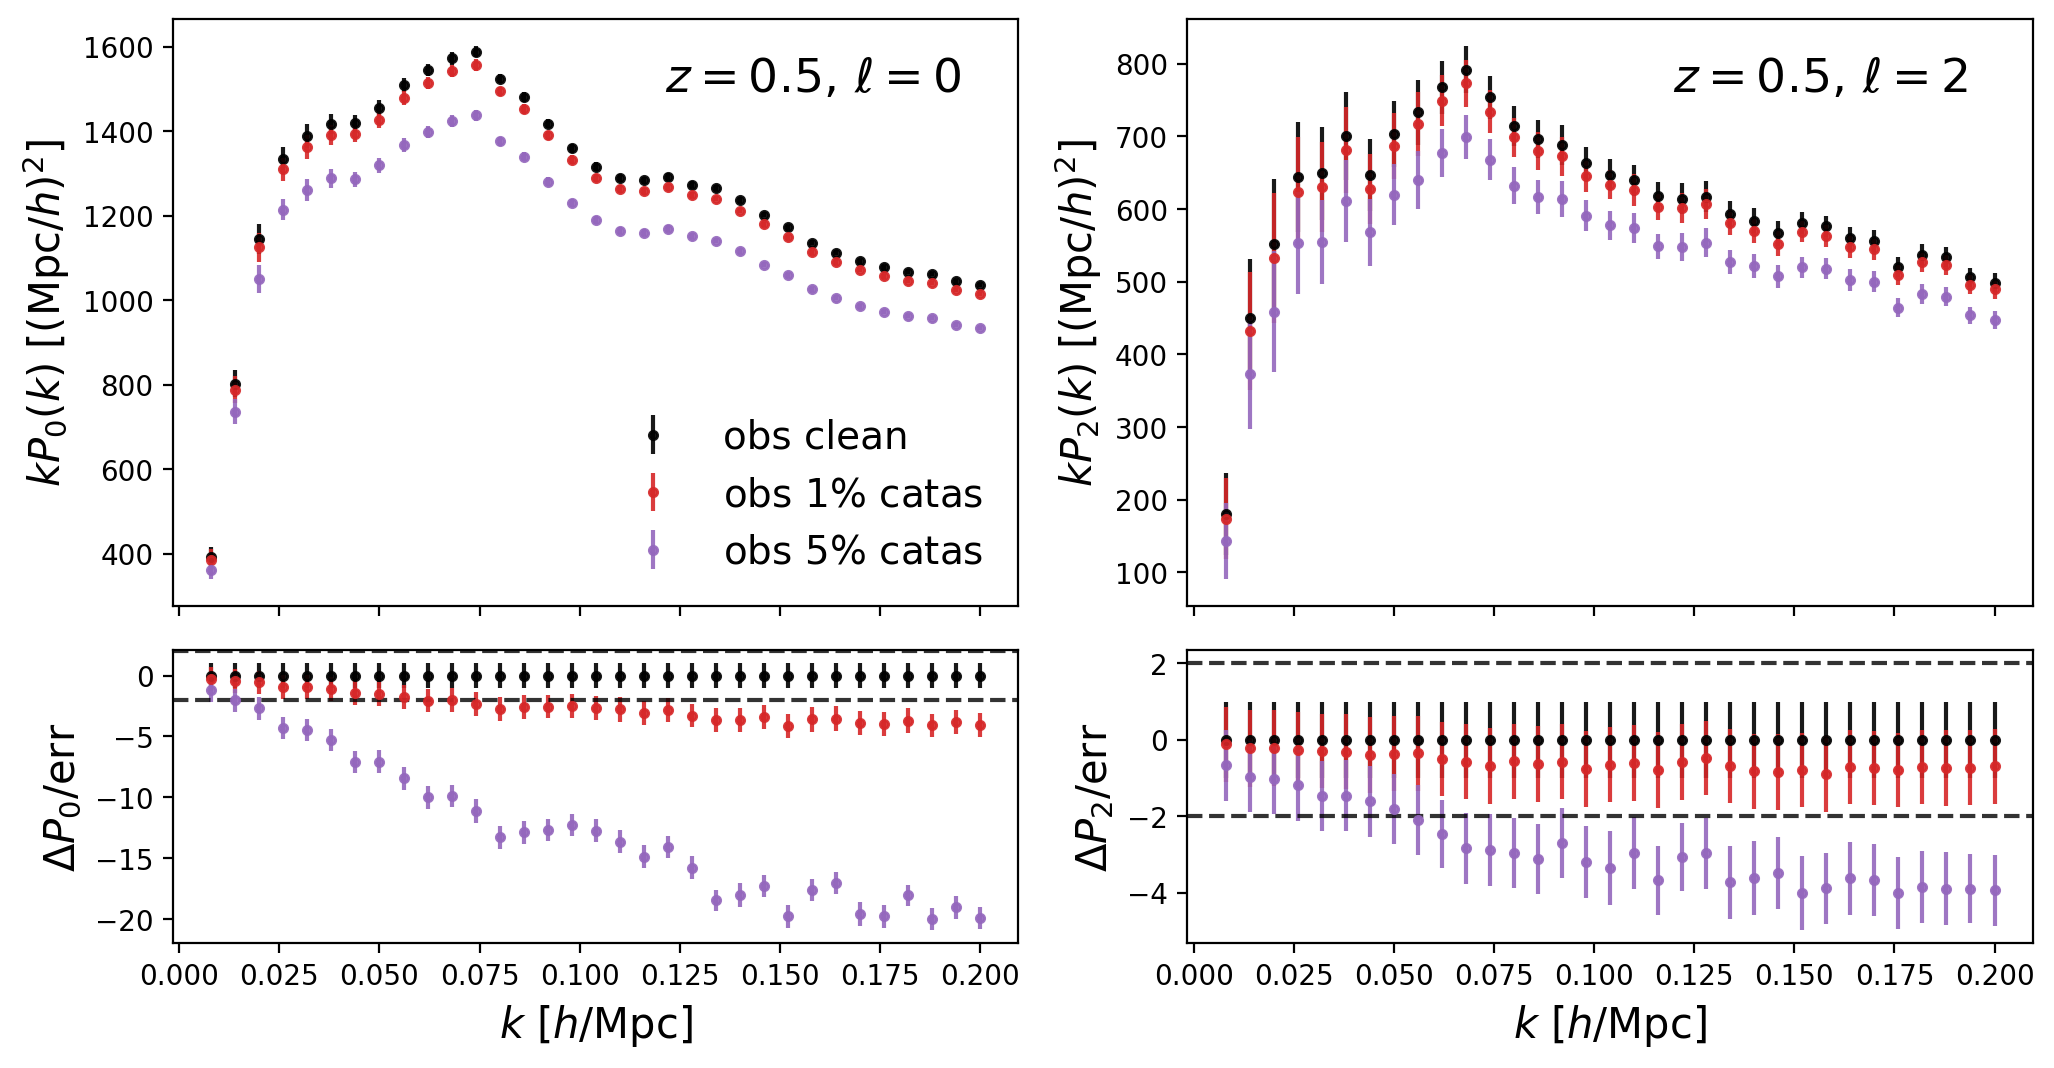

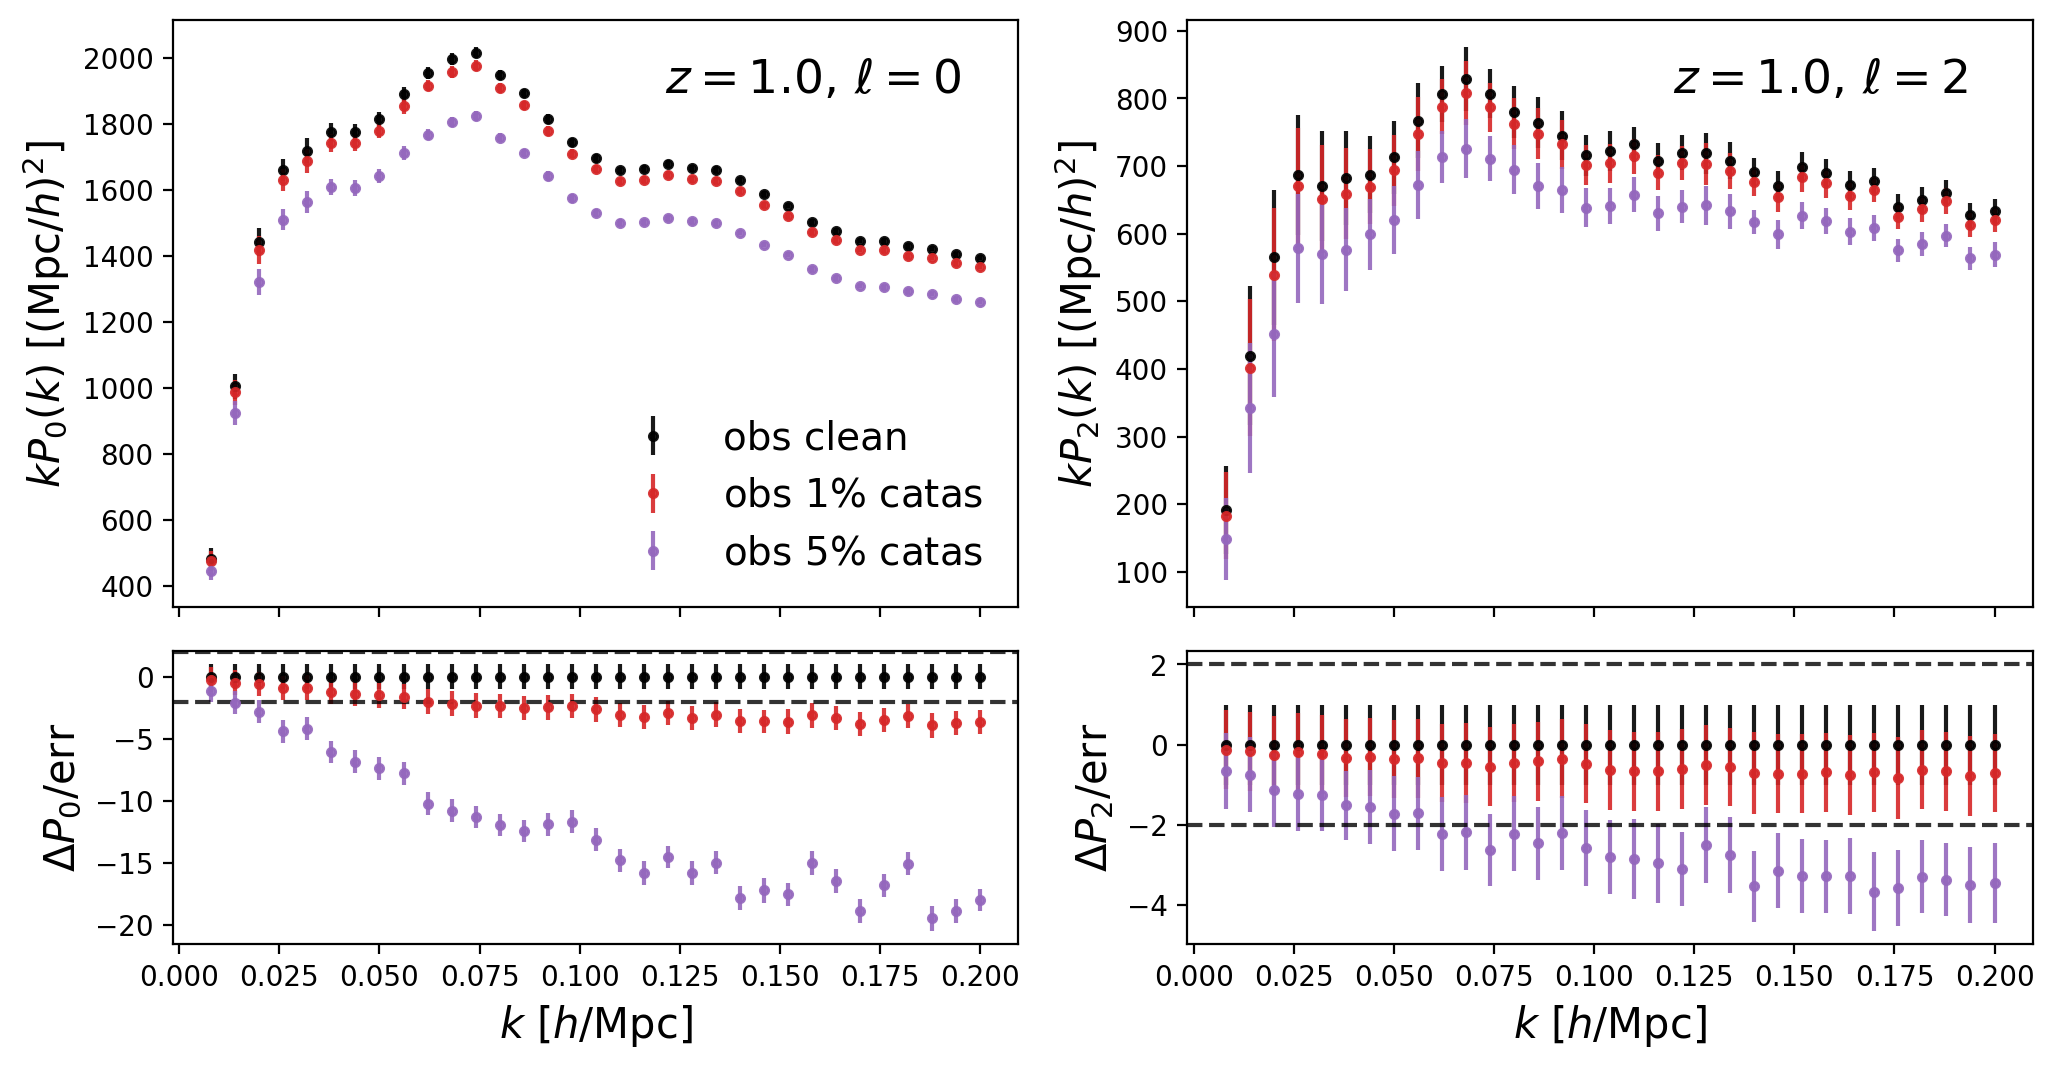

In [102]:
systematic_map  = {
    'RSD': 'fiducial',
    'LRG': '+LRGvsmear',
    'QSO': '+QSOvsmear',
    '1%CATAS': '+1%vcatas',
    '5%CATAS': '+5%vcatas'
    }

labels = [r'obs clean', r'$\rm{obs} \ 1\% \ catas $', r'$\rm{obs} \ 5\% \ catas $']
ylabels = [r'$k P_0(k)$ [$(\mathrm{Mpc}/h)^{2}$]',r'$k P_2(k)$ [$(\mathrm{Mpc}/h)^{2}$]']

label_fontsize = 15
for z, redshift in enumerate([0.5, 1.0]):
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize = (12, 6),  
                        gridspec_kw={'height_ratios':[2]+[1]})
    fig.subplots_adjust(hspace=0.1)
    Pkobs   = []
    colors  = ['black','C3','C4']
    for t,r_pk in enumerate(['RSD','1%CATAS','5%CATAS']):
        systematic = systematic_map.get(r_pk, '')
        [k_ev, pk0, pk2, cov] = Pkload('fiducial', r_pk, redshift)
        Pkobs.append([pk0, pk2])
        if t == 0:
            klen = len(k_ev)
            ref =  [i[0] for i in [pk0, pk2]] 
            errbar = [i[1] for i in [pk0, pk2]]
    for ell, l in zip(['monopole','quadrupole'],range(2)):
        values   = [np.zeros(klen), ref[l]]      
        err   = [np.ones(klen),k_ev*errbar[l]/rsf]
        for j in range(2):
            for t in range(len(Pkobs)):
                # if t ==0:
                #     axs[j][l].fill_between(k_ev,  k_ev*(Pkobs[t][l][0]-values[j]+Pkobs[t][l][1])/err[j] ,
                #         k_ev*(Pkobs[t][l][0]-values[j]-Pkobs[t][l][1])/err[j],alpha=0.6, color='grey')
                axs[j][l].errorbar(k_ev,  k_ev*(Pkobs[t][l][0]-values[j])/err[j], k_ev*Pkobs[t][l][1]/err[j]/rsf,
                                color = colors[t], label = labels[t], fmt='.', alpha = 0.9)        
            if j == 0:
                axs[j][l].set_ylabel(ylabels[l], fontsize = label_fontsize)
                leg1= axs[j][0].legend(loc=4, fontsize=14)
                leg1.get_frame().set_linewidth(0.0)
            if j == 1:
                axs[j][l].set_ylabel(r'$\Delta P_{}$/err'.format(l*2), fontsize = label_fontsize)
                for offset in [-2., 2.]: axs[j][l].axhline(offset, color='k', linestyle='--', alpha=0.8)
        axs[-1,l].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]', fontsize = label_fontsize)
    # plt.xlim([0.008,0.201])
    plt.figtext(0.33, 0.82, r'$z={}, \, \ell=0 $'.format(redshift), fontsize=17)
    plt.figtext(0.75, 0.82, r'$z={},  \, \ell=2 $'.format(redshift), fontsize=17)
plt.show()